In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -o /content/drive/MyDrive/final_project/data.zip -d /content
!mkdir /content/data/myaug

Archive:  /content/drive/MyDrive/final_project/data.zip
   creating: /content/data/
   creating: /content/data/images/
  inflating: /content/data/images/1UP47_2103_2418.png  
  inflating: /content/data/images/1UP47_2103_2418_1.png  
  inflating: /content/data/images/1UP47_2103_2419.png  
  inflating: /content/data/images/1UP47_2103_2419_1.png  
  inflating: /content/data/images/1UP47_2103_2419_3.png  
  inflating: /content/data/images/1UP47_2103_2420.png  
  inflating: /content/data/images/1UP47_2103_2420_1.png  
  inflating: /content/data/images/1UP47_2103_2420_3.png  
  inflating: /content/data/images/1UP47_2103_2420_5.png  
  inflating: /content/data/images/1UP47_2103_2421.png  
  inflating: /content/data/images/1UP47_2103_2421_1.png  
  inflating: /content/data/images/1UP47_2103_2421_5.png  
  inflating: /content/data/images/1UP47_2103_2423_3.png  
  inflating: /content/data/images/1UP47_2103_2423_5.png  
  inflating: /content/data/images/1V857S_2103_6509.png  
  inflating: /conten

In [3]:
!unzip -o /content/drive/MyDrive/final_project/testdata.zip -d /content

Archive:  /content/drive/MyDrive/final_project/testdata.zip
   creating: /content/testdata/
   creating: /content/testdata/t1/
  inflating: /content/testdata/t1/neg1.png  
  inflating: /content/testdata/t1/pos.png  
  inflating: /content/testdata/t1/query.png  
   creating: /content/testdata/t2/
  inflating: /content/testdata/t2/neg1.png  
  inflating: /content/testdata/t2/neg2.png  
  inflating: /content/testdata/t2/neg3.png  
  inflating: /content/testdata/t2/neg4.png  
  inflating: /content/testdata/t2/pos.png  
  inflating: /content/testdata/t2/query.png  
   creating: /content/testdata/t3/
  inflating: /content/testdata/t3/neg1.png  
  inflating: /content/testdata/t3/neg2.png  
  inflating: /content/testdata/t3/neg3.png  
  inflating: /content/testdata/t3/pos.png  
  inflating: /content/testdata/t3/query.png  


# Training Section

## Import Packages

In [4]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

## Configurations and Data

In [5]:
DATA_DIR = '/content/data/images/'
DATA_AUG_DIR = '/content/data/myaug/'
TRAIN_CSV_FILE = '/content/data/train.csv'
VALID_CSV_FILE = '/content/data/valid.csv'

BATCH_SIZE = 12

# 0~1
TRAINING_SIZE = None

DEVICE = 'cuda'
MODEL_PATH = '/content/drive/MyDrive/final_project/best_model.pt'

In [6]:
def abort():
  raise(RuntimeError("Aborted."))

In [7]:
#@title functions for data augmentations

from PIL import Image
from skimage.util import random_noise

###################
#      utils      #
###################

def clip(img, file_name, process, showwarns = False):
  if showwarns:
    if np.max(img) > 65535:
      print(f"Warning: {file_name} in {process.upper()} pixel value is larger than 65535, clip to 65535.")

    elif np.min(img) < 0:
      print(f"Warning: {file_name} in {process.upper()} pixel value is smaller than 0, clip to 0.")

  return np.clip(img, 0, 65535)


def normal_rand(min=-1, max=1, mu=None, sig=None):
  if mu is None:
    mu = (min+max)/2
  
  if sig is None:
    sig = np.abs(min-max)/4
  
  rand = np.random.normal(mu, sig)
  rand = np.clip(rand, min,max)
  return rand

###################
#    data augs    #
###################

"""
img must be GRAYSCALE color space
"""
def depth_change(img, file, b):
  depth = normal_rand()*b
  img = img + depth
  img = clip(img, file, process="depth_change")
  return img.astype(np.uint16)

"""
b: max degree of rotation
"""
def rotate(img, file, b=15):
    angle = normal_rand()*b
    scale = np.abs(np.sin(angle*np.pi/180))*0.3
    M = cv2.getRotationMatrix2D((img.shape[1]//2, img.shape[0]//2), angle, 1 + scale)
    img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    
    return img


def ratio_change(img, file, b=(300, 300)):

  img = cv2.resize(img, b)
    
  return img


def crop(img, file, b=0.1):
  if b >= 1 or b<0:
    raise ValueError("b should be in the interval {0,1)")
  
  dx = int(img.shape[1] * (1-b) + normal_rand(0,1, mu=1) * img.shape[1] * b)
  dy = int(img.shape[0] * (1-b) + normal_rand(0,1, mu=1) * img.shape[0] * b)
  x = img.shape[1] - dx
  y = img.shape[0] - dy

  crop_img = img[y: y + dy, x: x + dx]

  # print(crop_img.shape)
  if (len(crop_img.shape) != 2) or (0 in crop_img.shape):
    # Do nothing
    print(f"Warning: {file} in {crop.__name__.upper()} is bypassed.")
    return img

  else:
    return crop_img
  
def addnoise(img, file, gaussian=0.05, salt=0.05):

  img = random_noise(img, mode='gaussian', var=gaussian)

  amount = normal_rand()*salt

  coords = np.zeros_like(img, dtype=np.bool)
  coords = np.random.rand(*coords.shape) < amount
  img[coords] = 1.

  img = img*65535

  return img.astype(np.uint16)

def rotate_y_axis(img, file, b=15):
  angle = normal_rand()*b
  angle = angle*np.pi/180
  w = img.shape[1]
  h = img.shape[0]

  A1 = np.array([[1, 0, -w/2],
                  [0, 1, -h/2],
                  [0, 0, 1],
                  [0, 0, 1]])
  
  A2 = np.array([ [1, 0, w/2, 0],
                  [0, 1, h/2, 0],
                  [0, 0, 1, 0]])
                
  RY = np.array([[np.cos(angle), 0, -np.sin(angle), 0],
                 [0, 1, 0, 0],
                 [np.sin(angle), 0, np.cos(angle), 0],
                 [0, 0, 0, 1]])

  M = np.dot(A2, np.dot(RY, A1))
  
  img = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
  
  return img
  

In [8]:
def data_augmentations(files, iters = 5):
  for f in range(len(files)):
    file = files[f]
    print(f"Proccessing {f+1}/{len(files)}")
    # iter = np.random.randint(0, iters)
    for i in range(iters):
      # original data
      img = cv2.imread(DATA_DIR + file, -1)
      
      # depth changes
      if np.random.rand()<2:
        img = depth_change(img, file, 2**10)

      # y axis rotate
      if np.random.rand()<0.5:
        img = rotate_y_axis(img, file, 0.05)

      # rotate
      if np.random.rand()<0.5:
        img = rotate(img, file, 8)

      # crop
      if np.random.rand()<0.5:
        img = crop(img, file, 0.1)

      # ratio strictly change to 300*300
      img = ratio_change(img, file, (300, 300))
      
      # noise
      img = addnoise(img, file, gaussian = 1e-8, salt = 0.005)
      print(np.min(img), np.max(img))
      # print(img.dtype)
      # save
      cv2.imwrite(DATA_AUG_DIR + file.split(".")[0] + "_" + str(i+1) + ".png", img)

  return img, file #return last img to demo
        


rm: cannot remove '/content/data/myaug/*': No such file or directory
Proccessing 1/118
0 65535
0 35150
0 36260
0 65535
Proccessing 2/118
12628 65535
0 65535
11946 13209
0 13522
Proccessing 3/118
0 31996
0 65535
0 65535


<ipython-input-7-4dafbe5e9049>:90: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coords = np.zeros_like(img, dtype=np.bool)


0 65535
Proccessing 4/118
0 65535
0 35149
0 35087
0 35473
Proccessing 5/118
0 65535
115 65535
0 65535
427 33379
Proccessing 6/118
0 65535
1007 34718
417 34131
0 33824
Proccessing 7/118
0 65535
0 34417
0 36010
0 35835
Proccessing 8/118
0 30609
0 31101
0 65535
0 30926
Proccessing 9/118
0 65535
245 30355
123 65535
525 30643
Proccessing 10/118
0 65535
0 34014
380 65535
0 34477
Proccessing 11/118
0 33328
0 65535
0 32858
0 32157
Proccessing 12/118
0 32799
0 65535
0 65535
40 33621
Proccessing 13/118
0 33194
0 65535
0 65535
0 65535
Proccessing 14/118
0 65535
16201 65535
0 17901
0 17848
Proccessing 15/118
0 65535
0 27905
0 28286
0 28483
Proccessing 16/118
0 25810
0 25976
444 26447
0 25026
Proccessing 17/118
0 8580
0 8937
195 65535
0 65535
Proccessing 18/118
163 65535
0 31450
0 65535
0 65535
Proccessing 19/118
0 65535
0 33944
0 65535
0 34268
Proccessing 20/118
0 65535
0 65535
8650 34055
0 65535
Proccessing 21/118
0 65535
0 32534
0 65535
0 65535
Proccessing 22/118
14315 15779
0 65535
13445 14904


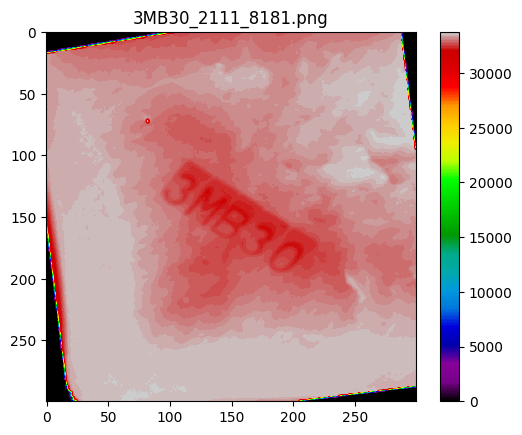

updating: content/drive/MyDrive/final_project/myaug/ (stored 0%)
updating: content/drive/MyDrive/final_project/myaug/9ZX48S_220624_200_1.png (deflated 1%)
updating: content/drive/MyDrive/final_project/myaug/9ZX48S_220624_200_2.png (deflated 1%)
updating: content/drive/MyDrive/final_project/myaug/9ZX48S_220624_200_3.png (deflated 1%)
updating: content/drive/MyDrive/final_project/myaug/9ZX48S_220624_200_4.png (deflated 1%)
updating: content/drive/MyDrive/final_project/myaug/2GW65S_2202_6980_1.png (deflated 1%)
updating: content/drive/MyDrive/final_project/myaug/2GW65S_2202_6980_2.png (deflated 1%)
updating: content/drive/MyDrive/final_project/myaug/2GW65S_2202_6980_3.png (deflated 1%)
updating: content/drive/MyDrive/final_project/myaug/2GW65S_2202_6980_4.png (deflated 1%)
updating: content/drive/MyDrive/final_project/myaug/3MB30_2111_8178_1.png (deflated 1%)
updating: content/drive/MyDrive/final_project/myaug/3MB30_2111_8178_2.png (deflated 1%)
updating: content/drive/MyDrive/final_proje

In [9]:
import os

# Data augmentations
run_data_augmentations = 1
if run_data_augmentations:
  !rm /content/data/myaug/*
  all_files = os.listdir(DATA_DIR)
  files = []
  for file in all_files:
    if len(file.split("_")) <= 3:
      files.append(file)

  img, last_file = data_augmentations(files, iters = 4)
  plt.imshow(img, cmap = 'nipy_spectral')
  plt.colorbar()
  plt.title(last_file)
  plt.show()
  
  !zip -r /content/drive/MyDrive/final_project/myaug.zip /content/drive/MyDrive/final_project/myaug/

else:
  
  !unzip -o /content/drive/MyDrive/final_project/myaug.zip -d /content/data/myaug

[]

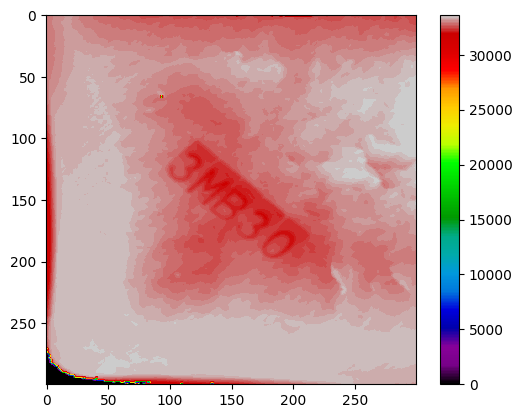

In [10]:
img_org = cv2.imread(DATA_DIR + "/" + last_file, -1).astype(np.int32)
plt.imshow(img_org, cmap = 'nipy_spectral')
plt.colorbar()
plt.plot()


In [11]:
#@title Image Preproccessing

from skimage.restoration import denoise_bilateral
from scipy import signal

sobel_h = np.array([[ -1 , 0 , 1 ] ,
                    [ -2 , 0 , 2 ] ,
                    [ -1 , 0 , 1 ]])
sobel_v = sobel_h.transpose()

def sobel( img ):

  x = cv2.Sobel(img, cv2.CV_16S, 1, 0, ksize=3) 
  y = cv2.Sobel(img, cv2.CV_16S, 0, 1, ksize=3)

  # to uint8
  absX = cv2.convertScaleAbs(x)
  absY = cv2.convertScaleAbs(y)

  # merge x and y
  dst = cv2.addWeighted(absX, 0.5, absX,0.5,0)

  return (dst/255.*65535.).astype(np.uint16)


def data_preproccessing(img):
  # [300, 300]
  # img type must be np.uint16
  
  img = cv2.medianBlur(img,3)
  img = sobel(img)
  
  # [300, 300]
  return img

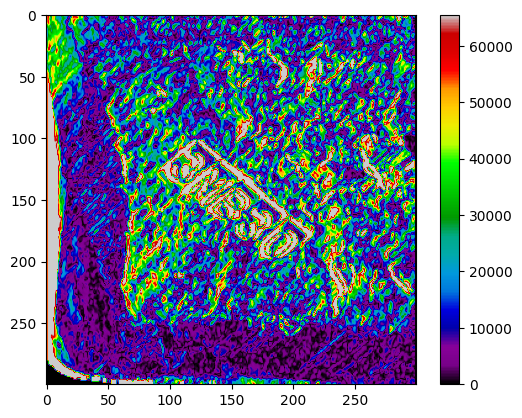

In [12]:
# denoise experiment
if run_data_augmentations:
  img_org = cv2.imread(DATA_DIR + "/" + last_file, -1).astype(np.uint16)
  img_den = data_preproccessing(img_org)

  plt.imshow(img_den, cmap = 'nipy_spectral')
  plt.colorbar()
  plt.plot()

  # abort()

In [13]:
#@title Make DataFrame

import os
import pandas as pd
import itertools

all_files = os.listdir(DATA_DIR)
anchor_files = []

for file in all_files:
  if len(file.split("_")) <= 3:
    anchor_files.append(file)

aug_files = os.listdir(DATA_AUG_DIR)
all_df = []
for i in range(len(anchor_files)):
    anchor_name = anchor_files[i].split(".")[0]
    for j in range(len(aug_files)):
      aug_name = aug_files[j].split(".")[0]
  
      if anchor_name in aug_name: # Positive
        all_df.append({
            'Anchor': anchor_files[i],
            'img': aug_files[j],
            'label': 1,
        })

      else: # Negative
        all_df.append({
            'Anchor': anchor_files[i],
            'img': aug_files[j],
            'label': 0,
        })

all_df = pd.DataFrame(all_df)
all_df_1 = all_df.loc[all_df["label"] == 1]
all_df_0 = all_df.loc[all_df["label"] == 0]

if TRAINING_SIZE is not None:
  
  all_df_1 = all_df_1[:int(TRAINING_SIZE*len(all_df_1))]
  all_df_0 = all_df_0[:int(TRAINING_SIZE*len(all_df_0))]

print(int(len(all_df_1)))
print(int(len(all_df_0)))

val_split = 0.2
train_1, val_1 = np.split(all_df_1.sample(frac=1, random_state=42), [int((1-val_split)*len(all_df_1))])
train_0, val_0 = np.split(all_df_0.sample(frac=1, random_state=42), [int((1-val_split)*len(all_df_0))])

train_df_proc = pd.concat([train_1, train_0])
valid_df_proc = pd.concat([val_1, val_0])




472
55224


In [14]:
# train_df_proc
#val_df_proc

print(len(train_df_proc))
print(len(valid_df_proc))
print(len(all_df))

train_df_proc.head(10)

44556
11140
55696


,Anchor,img,label
6481,1XL17_220624_487.png,1XL17_220624_487_3.png,1
8750,2H824_2202_13415.png,2H824_2202_13415_3.png,1
4033,2H824_2202_14475.png,2H824_2202_14475_2.png,1
32916,2H824_2202_15505.png,2H824_2202_15505_4.png,1
28801,3MB30_2111_7202.png,3MB30_2111_7202_1.png,1
44848,2H824_2202_15517.png,2H824_2202_15517_4.png,1
24979,2GW64S_2202_1628.png,2GW64S_2202_1628_1.png,1
1016,2H824_2202_15504.png,2H824_2202_15504_4.png,1
14930,2H824_2202_13419.png,2H824_2202_13419_2.png,1
8348,1XR21_2202_14616.png,1XR21_2202_14616_2.png,1


## Dataset and Dataloader

In [15]:
class dataset(Dataset):
  def __init__(self, df):
    self.df = df
  def __len__(self):
    return len(self.df)
    
  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    A_img = cv2.imread(DATA_DIR + row.Anchor, -1).astype(np.uint16)
    # [300, 300]
    A_img = data_preproccessing(A_img)
    A_img = torch.from_numpy(A_img.astype(np.int32)).unsqueeze(2).permute(2, 0, 1) / 65535.0


    Img = cv2.imread(DATA_AUG_DIR + row.img, -1).astype(np.uint16)
    # [300, 300]
    Img = data_preproccessing(Img)
    Img = torch.from_numpy(Img.astype(np.int32)).unsqueeze(2).permute(2, 0, 1) / 65535.0
    label = torch.from_numpy(np.array([row.label]).astype(np.float32))
    return A_img, Img, label

In [16]:
trainset = dataset(train_df_proc)
validset = dataset(valid_df_proc)
print(f'Number of trainset : {len(trainset)}')
print(f'Number of validset : {len(validset)}')

Number of trainset : 44556
Number of validset : 11140


In [17]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [18]:
print(f"Number of batches in trainloader : {len(trainloader)}")
print(f"Number of batches in validloader : {len(validloader)}")

Number of batches in trainloader : 3713
Number of batches in validloader : 929


In [19]:
for A, img, label in trainloader:
  # print(torch.max(img))
  break
    
print(f"Image batch shape : {A.shape}")
print(f"Image batch shape : {img.shape}")
print(f"label batch shape : {label.shape}")

Image batch shape : torch.Size([12, 1, 300, 300])
Image batch shape : torch.Size([12, 1, 300, 300])
label batch shape : torch.Size([12, 1])


## Model 

In [20]:
class FeatureExtraction(nn.Module):
  def __init__(self):
    super(FeatureExtraction, self).__init__()
    
    self.net = nn.Sequential(
      nn.Conv2d(1, 64, kernel_size=3,stride=1),
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(64),
      nn.MaxPool2d(3, stride=2),
      
      nn.Conv2d(64, 128, kernel_size=3,stride=1,padding=2),
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(128),
      nn.MaxPool2d(3, stride=2),

      nn.Conv2d(128, 256 , kernel_size=3,stride=1,padding=1),
      nn.ReLU(inplace=True),
      
      nn.Conv2d(256, 64 , kernel_size=3,stride=1,padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(3, stride=2),
      nn.Flatten())


    self.fcl = nn.Sequential(
      nn.Linear(82944, 128),
      nn.ReLU(inplace=True),
      nn.Linear(128, 64),
      nn.ReLU(inplace=True),
      nn.Linear(64, 16))
    
    # self.sigm = nn.Sigmoid()
  def forward(self, images):
    # images = self.prelayer(images)
    images = self.net(images)
    images = self.fcl(images)
    # images = self.sigm(images)
    return images

In [21]:
class SiameseNet(nn.Module):
    def __init__(self):
        super(SiameseNet, self).__init__()
        self.feat_extract = FeatureExtraction()

    def forward(self, imgA, imgB):
        embsA = self.feat_extract.forward(imgA)
        embsB = self.feat_extract.forward(imgB)
        embsA = nn.functional.normalize(embsA, p=2, dim=1)
        embsB = nn.functional.normalize(embsB, p=2, dim=1)

        return embsA, embsB


In [22]:
class ContrastiveLoss(nn.Module):
  def __init__(self, m=1):
    super(ContrastiveLoss, self).__init__()
    self.m = m

  def forward(self, embsA, embsB, label):

    diff = embsB - embsA
    dist_sq = torch.sum(torch.pow(diff, 2), 1)
    dist = torch.sqrt(dist_sq)
    label = label.t()
    mdist = self.m - dist
    loss = label * dist_sq + (1 - label) * torch.pow(torch.clamp(mdist, min=0.0), 2)
    loss = torch.sum(loss) / 2.0 / embsA.size()[0]

    return loss, dist

## Train and Evaluation Function

In [23]:
def batch_dist(a_emb, b_emb):
  dist = a_emb - b_emb
  dist = np.dot(dist, dist.T)
  dist[dist < 0] = 0
  dist = np.diag(np.sqrt(dist))
  return dist

In [24]:
def train(model, loader, optimizer, criterion):
  total_loss = 0.0
  total_eval = 0
  total_corr = 0
  for A, img, label in tqdm(loader):
    A = A.to(DEVICE); img = img.to(DEVICE); label = label.to(DEVICE)
    
    embsA, embsB = model(A, img)

    optimizer.zero_grad()
    loss, dist = criterion(embsA, embsB, label)
    loss.backward()
    optimizer.step()

    label = label.t().squeeze()

    for i in range(len(label)):
      for j in range(i, len(label)):
        if(label[i] != label[j]):
          if(label[i] == 1):
            total_corr += (dist[i] < dist[j])
            total_eval += 1
    total_loss += loss.item()

  return total_loss/len(loader), round(total_corr.item()/total_eval, 7)*100

In [25]:
def eval(model, loader):
  total_loss = 0.0
  total_eval = 0
  total_corr = 0
  with torch.no_grad():
    for A, img, label in tqdm(loader):
      A = A.to(DEVICE); img = img.to(DEVICE); label = label.to(DEVICE)
      embsA, embsB = model(A, img)
      loss, dist = criterion(embsA, embsB, label)
      
      label = label.t().squeeze()
      for i in range(len(label)):
        for j in range(i, len(label)):
          if(label[i] != label[j]):
            if(label[i] == 1):
              total_corr += (dist[i] < dist[j])
              total_eval += 1
              
      total_loss += loss.item()

    return total_loss/len(loader), round(total_corr.item()/total_eval, 7)*100

In [26]:
# Init
model = SiameseNet();
model.to(DEVICE);

In [27]:
criterion = ContrastiveLoss(m=1)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, weight_decay=0.0005)
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)


In [28]:
checkpoint_dir = "/content/drive/MyDrive/final_project/checkpoints/"


best_valid_acc = 0
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []


In [29]:
def load_from_checkpoint(model, optimizer, filepath):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    filename = filepath + "checkpoints"

    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))

        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        train_acc = checkpoint['train_acc']
        train_loss = checkpoint['train_loss']
        valid_acc = checkpoint['valid_acc']
        valid_loss = checkpoint['valid_loss']
        best_valid_acc = checkpoint['best_valid_acc']

        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))
        best_valid_acc = 0
        train_loss = []
        valid_loss = []
        train_acc = []
        valid_acc = []

    return model, optimizer, start_epoch, (train_acc, train_loss, valid_acc, valid_loss, best_valid_acc)


In [30]:
# load from checkpoints if needed

filepath = checkpoint_dir
start_epoch = 0
model, optimizer, start_epoch, (train_acc, train_loss, valid_acc, valid_loss, best_valid_acc) = load_from_checkpoint(model, optimizer, filepath = filepath)

model

=> loading checkpoint '/content/drive/MyDrive/final_project/checkpoints/checkpoints'
=> loaded checkpoint '/content/drive/MyDrive/final_project/checkpoints/checkpoints' (epoch 10)


SiameseNet(
  (feat_extract): FeatureExtraction(
    (net): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
      (5): ReLU(inplace=True)
      (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (13): Flatten(start_dim=1, end_dim=-1)
    )
    (fcl): Sequent

In [ ]:
EPOCHS = 10

for idx in range(start_epoch, EPOCHS):
  
  print(f'EPOCH : {idx+1}')
  loss, acc = train(model, trainloader, optimizer, criterion)
  train_loss.append(loss)
  train_acc.append(acc)

  loss, acc = eval(model, validloader)
  valid_loss.append(loss)
  valid_acc.append(acc)

  if valid_acc[-1] >= best_valid_acc:
    torch.save(model.state_dict(), MODEL_PATH)
    best_valid_acc = valid_acc[-1]
    print('[WEIGHTS SAVED]')


  to_save = {'epoch': idx + 1,
             'state_dict': model.state_dict(),
             'optimizer': optimizer.state_dict(),
             'train_acc': train_acc,
             'train_loss': train_loss,
             'valid_acc': valid_acc,
             'valid_loss': valid_loss,
             'best_valid_acc': best_valid_acc
             }

  # checkpoints
  torch.save(to_save, checkpoint_dir + "checkpoints")
  print(f'train_loss : {train_loss[-1]} valid_loss : {valid_loss[-1]}')
  print(f'train_acc : {train_acc[-1]}% valid_acc : {valid_acc[-1]}%\n')

EPOCH : 7


100%|██████████| 929/929 [02:26<00:00,  6.35it/s]


[WEIGHTS SAVED]
train_loss : 0.0007238773703204798 valid_loss : 0.0008162344496594633
train_acc : 99.95049999999999% valid_acc : 100.0%

EPOCH : 8


100%|██████████| 929/929 [02:25<00:00,  6.37it/s]


[WEIGHTS SAVED]
train_loss : 0.0004395400197335556 valid_loss : 0.0007339987348972357
train_acc : 100.0% valid_acc : 100.0%

EPOCH : 9


100%|██████████| 929/929 [02:27<00:00,  6.32it/s]


[WEIGHTS SAVED]
train_loss : 0.00045607225192543545 valid_loss : 0.00041607006348836554
train_acc : 100.0% valid_acc : 100.0%

EPOCH : 10


100%|██████████| 929/929 [02:28<00:00,  6.27it/s]


[WEIGHTS SAVED]
train_loss : 0.00038941337536429284 valid_loss : 0.0005514745201758497
train_acc : 100.0% valid_acc : 100.0%



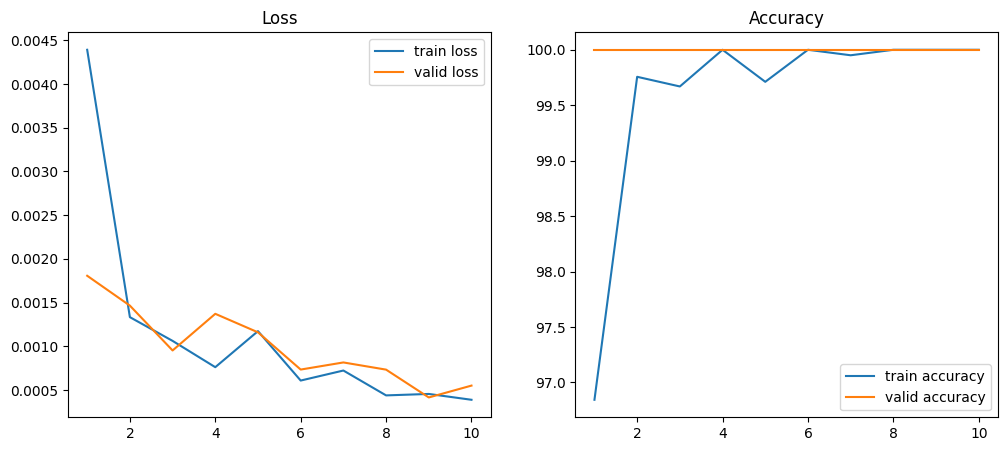

In [ ]:
# plot loss
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
ax1.set_title("Loss")
x = np.linspace(1,10, num = 10)
ax1.plot(x, train_loss, label='train loss')
ax1.plot(x, valid_loss, label='valid loss')
ax1.legend()

ax2.set_title("Accuracy")
ax2.plot(x, train_acc, label='train accuracy')
ax2.plot(x, valid_acc, label='valid accuracy')
ax2.legend()

plt.show()

# Test Section

## Import Packages

In [31]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
import seaborn as sns

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Configuration

In [33]:
DATA_DIR = '/content/testdata/'

DEVICE = 'cuda'
MODEL_PATH = '/content/drive/MyDrive/final_project/best_model.pt'

In [34]:
!unzip -o /content/drive/MyDrive/final_project/formal_testdata.zip -d /content

Archive:  /content/drive/MyDrive/final_project/formal_testdata.zip
  inflating: /content/testdata/t1/neg1.png  
  inflating: /content/testdata/t1/neg10.png  
  inflating: /content/testdata/t1/neg11.png  
  inflating: /content/testdata/t1/neg12.png  
  inflating: /content/testdata/t1/neg13.png  
  inflating: /content/testdata/t1/neg14.png  
  inflating: /content/testdata/t1/neg15.png  
  inflating: /content/testdata/t1/neg16.png  
  inflating: /content/testdata/t1/neg17.png  
  inflating: /content/testdata/t1/neg2.png  
  inflating: /content/testdata/t1/neg3.png  
  inflating: /content/testdata/t1/neg4.png  
  inflating: /content/testdata/t1/neg5.png  
  inflating: /content/testdata/t1/neg6.png  
  inflating: /content/testdata/t1/neg7.png  
  inflating: /content/testdata/t1/neg8.png  
  inflating: /content/testdata/t1/neg9.png  
  inflating: /content/testdata/t1/pos.png  
  inflating: /content/testdata/t1/query.png  
   creating: /content/testdata/t10/
  inflating: /content/testdata/t10

65535


[]

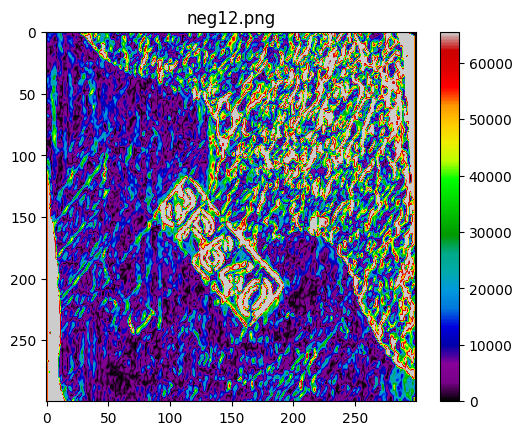

In [35]:
testcases = os.listdir(DATA_DIR)
img = []
filename = []
for testcase in testcases:
  files = os.listdir(DATA_DIR + "/" + testcase)
  for file in files:
    img.append(data_preproccessing(cv2.imread(DATA_DIR + "/" + testcase + "/" + file, -1).astype(np.uint16)).astype(np.int32))
    filename.append(file)

k = 6
print(np.max(img[k]))

plt.imshow(img[k], cmap = 'nipy_spectral')
plt.title(filename[k])
plt.colorbar()
plt.plot()

## Model
You can just copy the whole `class Model` in Training Section.

In [36]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.feat_extract = FeatureExtraction()

    def forward(self, imgA, imgB):
        embsA = self.feat_extract.forward(imgA)
        embsB = self.feat_extract.forward(imgB)
        embsA = nn.functional.normalize(embsA, p=2, dim=1)
        embsB = nn.functional.normalize(embsB, p=2, dim=1)

        return embsA, embsB


In [37]:
model = Model()
model.to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

## Test

In [38]:
def dist(a_emb, b_emb):
  dist = a_emb - b_emb
  dist = np.dot(dist, dist.T)
  dist[dist < 0] = 0
  dist = np.sqrt(dist)[0][0]
  return dist

In [39]:
def test(model, folder, candidates):

  query_img = cv2.imread(DATA_DIR + folder + 'query.png', -1).astype(np.uint16)
  query_img = data_preproccessing(query_img)
  query_img = torch.from_numpy(query_img.astype(np.int32)).unsqueeze(2).permute(2, 0, 1) / 65535.0
  query_img = query_img.unsqueeze(0).to(DEVICE)

  dists = {}
  scores = {}
  for cand in candidates:
    cand_img = cv2.imread(DATA_DIR + folder + cand, -1).astype(np.uint16)
    cand_img = data_preproccessing(cand_img)
    cand_img = torch.from_numpy(cand_img.astype(np.int32)).unsqueeze(2).permute(2, 0, 1) / 65535.0
    cand_img = cand_img.unsqueeze(0).to(DEVICE)
    embsA, embsB = model.forward(query_img, cand_img)
    diff = embsB - embsA
    dist_sq = torch.sum(torch.pow(diff, 2), 1)
    dists[cand] = torch.sqrt(dist_sq).item()

  return len(candidates)-1, np.count_nonzero([i > dists['pos.png'] for i in dists.values()]), dists

In [40]:
from datetime import datetime

testcases = os.listdir(DATA_DIR)
total_eval = 0
total_corr = 0
dists = []
for testcase in testcases:
  testcase += '/'
  files = os.listdir(DATA_DIR + testcase)
  files.remove('query.png')
  eval, corr, dist = test(model, testcase, files)
  dists.append(dist)
  total_eval += eval
  total_corr += corr

now = datetime.now()
today = datetime.today()

current_time = str(today) + str(now.strftime("%H:%M:%S"))

print("Current Time: ", current_time)
print("Number of test cases: ", len(testcases))
print(f'Test accuracy: {round(total_corr/total_eval, 7)*100}%')

Current Time:  2023-05-22 11:17:29.39436811:17:29
Number of test cases:  15
Test accuracy: 97.82609%


# Statistic

In [41]:
# !pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
import scipy

pos_dists = []
neg_dists = []

for dist in dists:
  for i in dist.items():
    if 'pos' in i[0]:
      pos_dists.append(i[1])
    else:
      neg_dists.append(i[1])

print(dists)
print(pos_dists)
print(neg_dists)
print(scipy.stats.mannwhitneyu(pos_dists, neg_dists, alternative = 'less'))
print(scipy.stats.ttest_ind(pos_dists, neg_dists, alternative= 'less'))

mu_neg = np.mean(neg_dists)
mu_pos = np.mean(pos_dists)
std_neg = np.std(neg_dists, ddof=1)
std_pos = np.std(pos_dists, ddof=1)


[{'neg4.png': 1.2007827758789062, 'neg2.png': 0.8722667098045349, 'pos.png': 0.27907878160476685, 'neg6.png': 0.9825620651245117, 'neg9.png': 0.8969672918319702, 'neg7.png': 1.004701018333435, 'neg12.png': 1.0368022918701172, 'neg8.png': 0.9396623969078064, 'neg11.png': 1.183380365371704, 'neg13.png': 0.8666558861732483, 'neg10.png': 1.1568254232406616, 'neg5.png': 0.9889481067657471, 'neg3.png': 1.1725164651870728, 'neg1.png': 1.0221588611602783}, {'neg4.png': 0.7999171614646912, 'neg2.png': 1.0348173379898071, 'pos.png': 0.2596903145313263, 'neg6.png': 0.5309972763061523, 'neg9.png': 0.8753101229667664, 'neg7.png': 0.9396623969078064, 'neg8.png': 0.9619609117507935, 'neg10.png': 0.6602139472961426, 'neg5.png': 0.6076076626777649, 'neg3.png': 1.0964008569717407, 'neg1.png': 1.1061981916427612}, {'neg4.png': 0.8631414771080017, 'neg30.png': 0.6213605403900146, 'neg16.png': 0.7833284735679626, 'neg32.png': 1.2841465473175049, 'neg26.png': 1.2217084169387817, 'neg28.png': 1.3772075176239

[]

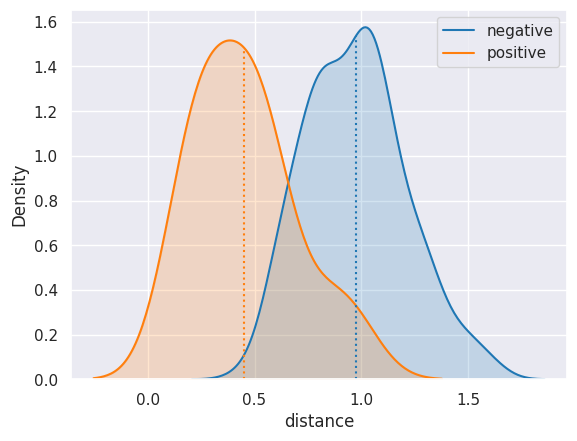

In [49]:

sns.set_theme()


ax = sns.kdeplot(neg_dists, label = "negative", fill = False, color='tab:blue')
sns.kdeplot(pos_dists, label = "positive", fill = False, color='tab:orange')

kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
left = mu_neg - std_neg
right = mu_neg + std_neg
height = np.interp(mu_neg, xs, ys)
ax.vlines(mu_neg, 0, height, ls=':', color='tab:blue')
ax.fill_between(xs, 0, ys, alpha=0.2, facecolor='tab:blue')
# ax.fill_between(xs, 0, ys, where=(left <= xs) & (xs <= right), interpolate=True, facecolor='tab:blue', alpha=0.1)


kdeline = ax.lines[1]
left = mu_pos - std_pos
right = mu_pos + std_pos
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
height = np.interp(mu_pos, xs, ys)
ax.vlines(mu_pos, 0, height, ls=':', color='tab:orange')
ax.fill_between(xs, 0, ys, alpha=0.2, color='tab:orange')
# ax.fill_between(xs, 0, ys, where=(left <= xs) & (xs <= right), interpolate=True, facecolor='tab:orange', alpha=0.1)


plt.legend()
plt.xlabel("distance")
plt.plot()


[]

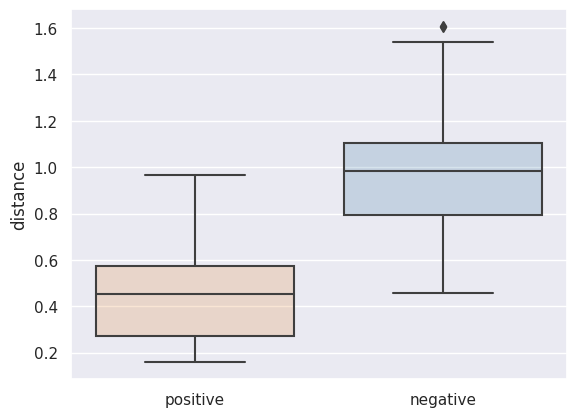

In [50]:
ax = sns.boxplot(data=[pos_dists, neg_dists], palette = ["tab:orange", "tab:blue"])
ax.set_xticklabels(["positive", "negative"])
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .2))
    r, g, b, a = patch.get_facecolor()
plt.ylabel("distance")
plt.plot()